# Housing Price Regression Modeling and Prediction
Author: Sandra Shtabnaya<br>
Course: DSCI 401 - Applied Machine Learning

In [412]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

## Import Data

In [413]:
model_data = pd.read_csv("AmesHousingSetA.csv")
validation_data = pd.read_csv("AmesHousingSetB.csv")

## Data Preparation
The data provided contains many omitted NaN values. Most omitted values are from columns with type "object" or string that relates to unusual attributes of a house, such as a pool and a fence.

In [414]:
model_data.info()
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 81 columns):
PID                2344 non-null int64
MS.SubClass        2344 non-null int64
MS.Zoning          2344 non-null object
Lot.Frontage       1946 non-null float64
Lot.Area           2344 non-null int64
Street             2344 non-null object
Alley              166 non-null object
Lot.Shape          2344 non-null object
Land.Contour       2344 non-null object
Utilities          2344 non-null object
Lot.Config         2344 non-null object
Land.Slope         2344 non-null object
Neighborhood       2344 non-null object
Condition.1        2344 non-null object
Condition.2        2344 non-null object
Bldg.Type          2344 non-null object
House.Style        2344 non-null object
Overall.Qual       2344 non-null int64
Overall.Cond       2344 non-null int64
Year.Built         2344 non-null int64
Year.Remod.Add     2344 non-null int64
Roof.Style         2344 non-null object
Roof.Matl          2

### Handling Missing Categorical Values
I will make the assumption that NaN in most cases means not applicable, so I will replace NaN with "None." This is with the exception of Fireplace, Basement and Garage related attributes, whose values can be deduced. For example, where fireplaces is 0, we can assume that all other fireplace attributes are "none."

#### Missing Basement Features

In [415]:
no_bsmt_m = (model_data["Total.Bsmt.SF"] == 0)
no_bsmt_v = (validation_data["Total.Bsmt.SF"] == 0)
bsmt_attributes = ["Bsmt.Qual", "Bsmt.Cond", "Bsmt.Exposure", "BsmtFin.Type.1", 
                   "BsmtFin.SF.1", "BsmtFin.Type.2", "BsmtFin.SF.2", "Bsmt.Unf.SF"]

# replace all NaN basement attributes to None, where basement square footage is 0.
for column in bsmt_attributes:
    model_data.loc[no_bsmt_m, column] = model_data.loc[no_bsmt_m, column].fillna("None")
    validation_data.loc[no_bsmt_v, column] = validation_data.loc[no_bsmt_v, column].fillna("None")

model_data.loc[no_bsmt_m, "Bsmt.Half.Bath"] = model_data.loc[no_bsmt_m, "Bsmt.Half.Bath"].fillna(0.0)
model_data.loc[no_bsmt_m, "Bsmt.Full.Bath"] = model_data.loc[no_bsmt_m, "Bsmt.Full.Bath"].fillna(0.0)

validation_data.loc[no_bsmt_v, "Bsmt.Half.Bath"] = validation_data.loc[no_bsmt_v, "Bsmt.Half.Bath"].fillna(0.0)
validation_data.loc[no_bsmt_v, "Bsmt.Full.Bath"] = validation_data.loc[no_bsmt_v, "Bsmt.Full.Bath"].fillna(0.0)

#### Missing Garage Features

In [416]:
no_garage_m = (model_data["Garage.Area"] == 0)
no_garage_v = (model_data["Garage.Area"] == 0)
garage_attributes = ['Garage.Type', 'Garage.Finish', 'Garage.Qual', 'Garage.Cond']

# replace all NaN garage attributes to None, where garage area is 0.
for column in garage_attributes:
    model_data.loc[no_garage_m, column] = model_data.loc[no_garage_m, column].fillna("None")
    validation_data.loc[no_garage_v, column] = model_data.loc[no_garage_v, column].fillna("None")

model_data.loc[no_garage_m, "Garage.Yr.Blt"] = model_data.loc[no_garage_m, "Garage.Yr.Blt"].fillna(0.0)
model_data.loc[no_garage_m, "Garage.Cars"] = model_data.loc[no_garage_m, "Garage.Cars"].fillna(0.0)

validation_data.loc[no_garage_v, "Garage.Yr.Blt"] = validation_data.loc[no_garage_v, "Garage.Yr.Blt"].fillna(0.0)
validation_data.loc[no_garage_v, "Garage.Cars"] = validation_data.loc[no_garage_v, "Garage.Cars"].fillna(0.0)

#### Missing Fireplace Features

In [417]:
# replace all NaN fireplace attributes with None, where total fireplaces is 0.
no_fireplc_m = (model_data.Fireplaces == 0)
no_fireplc_v = (validation_data.Fireplaces == 0)

model_data.loc[no_fireplc_m, 'Fireplace.Qu'] = model_data.loc[no_fireplc_m, 'Fireplace.Qu'].fillna("None")
validation_data.loc[no_fireplc_v, 'Fireplace.Qu'] = validation_data.loc[no_fireplc_v, 'Fireplace.Qu'].fillna("None")

# replace all NaN pool attributes with None, where pool area is 0.
no_pool_m = (model_data["Pool.Area"] == 0)
no_pool_v = (validation_data["Pool.Area"] == 0)

model_data.loc[no_pool_m, 'Pool.QC'] = model_data.loc[no_pool_m, 'Pool.QC'].fillna("None")
validation_data.loc[no_pool_v, 'Pool.QC'] = validation_data.loc[no_pool_v, 'Pool.QC'].fillna("None")

#### Missing Masonry Features
There are no instances where the specified masonry is 0, but the masonry type is NaN. Since most homes do not have masonry, I will replace the NaNs with 0 and None.

In [418]:
model_data[(model_data["Mas.Vnr.Area"] == 0) & (model_data["Mas.Vnr.Type"].isna())][["Mas.Vnr.Area", "Mas.Vnr.Type"]]

model_data["Mas.Vnr.Area"].fillna(0.0, inplace=True)
model_data["Mas.Vnr.Type"].fillna("None", inplace=True)

validation_data["Mas.Vnr.Area"].fillna(0.0, inplace=True)
validation_data["Mas.Vnr.Type"].fillna("None", inplace=True)

#### Missing Miscellaneous Features
The remaining missing values cannot be deduced, but we can assume that if they are missing, they do not apply to the house.

In [419]:
model_data["Alley"].fillna("None", inplace=True)
model_data["Fence"].fillna("None", inplace=True)
model_data["Misc.Feature"].fillna("None", inplace=True)

validation_data["Alley"].fillna("None", inplace=True)
validation_data["Fence"].fillna("None", inplace=True)
validation_data["Misc.Feature"].fillna("None", inplace=True)

### Checking Results
After making deducations, there still remain some categorical values that we cannot deduce. This includes all the basement and garage attributes.

In [420]:
model_data.info()
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344 entries, 0 to 2343
Data columns (total 81 columns):
PID                2344 non-null int64
MS.SubClass        2344 non-null int64
MS.Zoning          2344 non-null object
Lot.Frontage       1946 non-null float64
Lot.Area           2344 non-null int64
Street             2344 non-null object
Alley              2344 non-null object
Lot.Shape          2344 non-null object
Land.Contour       2344 non-null object
Utilities          2344 non-null object
Lot.Config         2344 non-null object
Land.Slope         2344 non-null object
Neighborhood       2344 non-null object
Condition.1        2344 non-null object
Condition.2        2344 non-null object
Bldg.Type          2344 non-null object
House.Style        2344 non-null object
Overall.Qual       2344 non-null int64
Overall.Cond       2344 non-null int64
Year.Built         2344 non-null int64
Year.Remod.Add     2344 non-null int64
Roof.Style         2344 non-null object
Roof.Matl          

### Imputing Categorical Columns
In this case, we can use aggregate statistics to pick a replacement that is representative of the overall column. This can be done using sklearn's simple imputer. We will use the mode for each column.

In [421]:
cat_imputer = SimpleImputer(strategy="most_frequent")
cat_mod_x = model_data.select_dtypes(include=['object'])
cat_valid_x = validation_data.select_dtypes(include=['object'])

cat_mod_x[:] = cat_imputer.fit_transform(cat_mod_x)
cat_valid_x[:] = cat_imputer.fit_transform(cat_valid_x)

C:\Users\sandra\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\sandra\Anaconda3\lib\site-packages\pandas\core\frame.py:3123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer(key, value)
C:\Users\sandra\Anaconda3\lib\site-packages\pandas\core\frame.py:3111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return self._setitem_slice(indexer, v

In [422]:
num_imputer = SimpleImputer(strategy="median", missing_values=np.nan)
num_mod_x = model_data._get_numeric_data()
num_valid_x = validation_data._get_numeric_data()

num_mod_x[:] = num_imputer.fit_transform(num_mod_x)
num_valid_x[:] = num_imputer.fit_transform(num_valid_x)
num_mod_x[:] = preprocessing.normalize(num_mod_x)
num_valid_x[:] = preprocessing.normalize(num_valid_x)

### One-Hot Encoding
The categorical values need to be one-hot encoded so that they are in numeric form for our regression models. The imputed categorical and numeric columns then need to be combined back together to form our processed data for training, testing and validation.

In [423]:
cat_mod = pd.get_dummies(cat_mod_x, columns=cat_mod_x.columns)
model_x = pd.concat([num_mod_x, cat_mod], axis=1).drop(["SalePrice"], axis=1)  # combine categorical and numeric values back
model_y = model_data.SalePrice

cat_valid = pd.get_dummies(cat_valid_x, columns=cat_valid_x.columns)
cat_valid = cat_valid.reindex(columns=cat_mod_x.columns, fill_value=0)  # account for missing categorical values
valid_x = pd.concat([num_valid_x, cat_valid], axis=1).drop(["SalePrice"], axis=1) # combine categorical and numeric values back
valid_y = validation_data.SalePrice

## Exploratory Analysis
We can look at relationships between each of the variables to the housing price by creating pairs plot. I split numeric and categorical columns into smaller sets, so that it is easier to generate and evaluate pair plots. Generating a KDE for sale price shows that most homes on the market in this dataset are in the lower price range.

### Exploring Numeric Features
In the first subset of ten columns, we notice that most lot frontage and area values are clustered in the lower range, and do not have an obvious relationship to price. Homes on the market in this dataset are either built or remodeled recently, or a long time ago. There are no homes in the middle year range for these attributes. There appears to be positive relationship between year built/remodeled and price. 

The relationship between the house's overall quality and price appears to be strong. As quality increases, so does the price. There appears to be a similar relationship between condition and price, although the strength of that relationship may be weaker (as mid-condition houses go for the highest prices). Finished basement square footage also has a strong positive relationship with price. While the price tends to increase with an increase in masonry veneer area, the relationship is weaker than with basement area.

The MS subclass attribute appears to have an inverse relationship with price, although it is possible that the values refer to a category, with no meaningful difference between quantities.

In [ ]:
sm = pd.plotting.scatter_matrix(num_mod_x.iloc[:, list(range(1, 10)) + [37]], diagonal='kde')
plt.show()

In [424]:
model_x = pd.get_dummies(model_x, columns=["MS.SubClass"])  # treat MS subclass as category
valid_x = pd.get_dummies(valid_x, columns=["MS.SubClass"])
valid_x = valid_x.reindex(columns=model_x.columns, fill_value=0)

The next set of attributes reveal that houses with greater square footage (in both basement and upper floors) tend to have higher prices. The relationship is strongest with living area and first/second floors. There does not appear to be as strong a relationship with basement full and half baths, although full bath totals do exhibit a positive linear relationship to price.

In [ ]:
sm = pd.plotting.scatter_matrix(num_mod_x.iloc[:, list(range(10, 20)) + [37]], diagonal='kde')
plt.show()

In the next set, the house attributes that seem to have the strongest affect on house price include total rooms above ground, garage area (and subsequently total garage cars) and garage age. Bedrooms above ground, fireplaces, deck and porch area also have a positive affect, but this relationsihp is much weaker.

In [ ]:
sm = pd.plotting.scatter_matrix(num_mod_x.iloc[:, list(range(20, 30)) + [37]], diagonal='kde')
plt.show()

Finally, the last set of numeric attributes do not appear to have any noticable relationship to sale price. Year sold does have a positive relationship, but this may be due to economic factors as well as data availability, since there is no data for houses between the oldest and newest years.

In [ ]:
sm = pd.plotting.scatter_matrix(num_mod_x.iloc[:, list(range(30, 37)) + [37]], diagonal='kde')
plt.show()

### Exploring Categorical Columns
There are a great deal of different categorical values to examine, so I decided to pick out several that I hypothesized would affect sale price the most, given my exploration of numeric columns. This includes neighborhood, sale condition, house style, garage quality and basement quality.

After creating boxplots, I observed that houses with "partial" sale conditions tend to have a higher price range, although the "normal" sale condition has many outliers in very high price ranges. Neighborhoods do appear to have varying price ranges. For example, homes in Meadow tend to be around 100K, while homes in North Ridge range from 200 to 450k. However, prices across the different house styles are rather similar.

Basement quality seems to have a considerable affect on price (about 100K more). Houses with "excellent" basements have much higher price ranges, as well as houses with "good" garages. Overall, I hypothesize that houses with more square footage and high quality garages and basements will have higher sale prices.

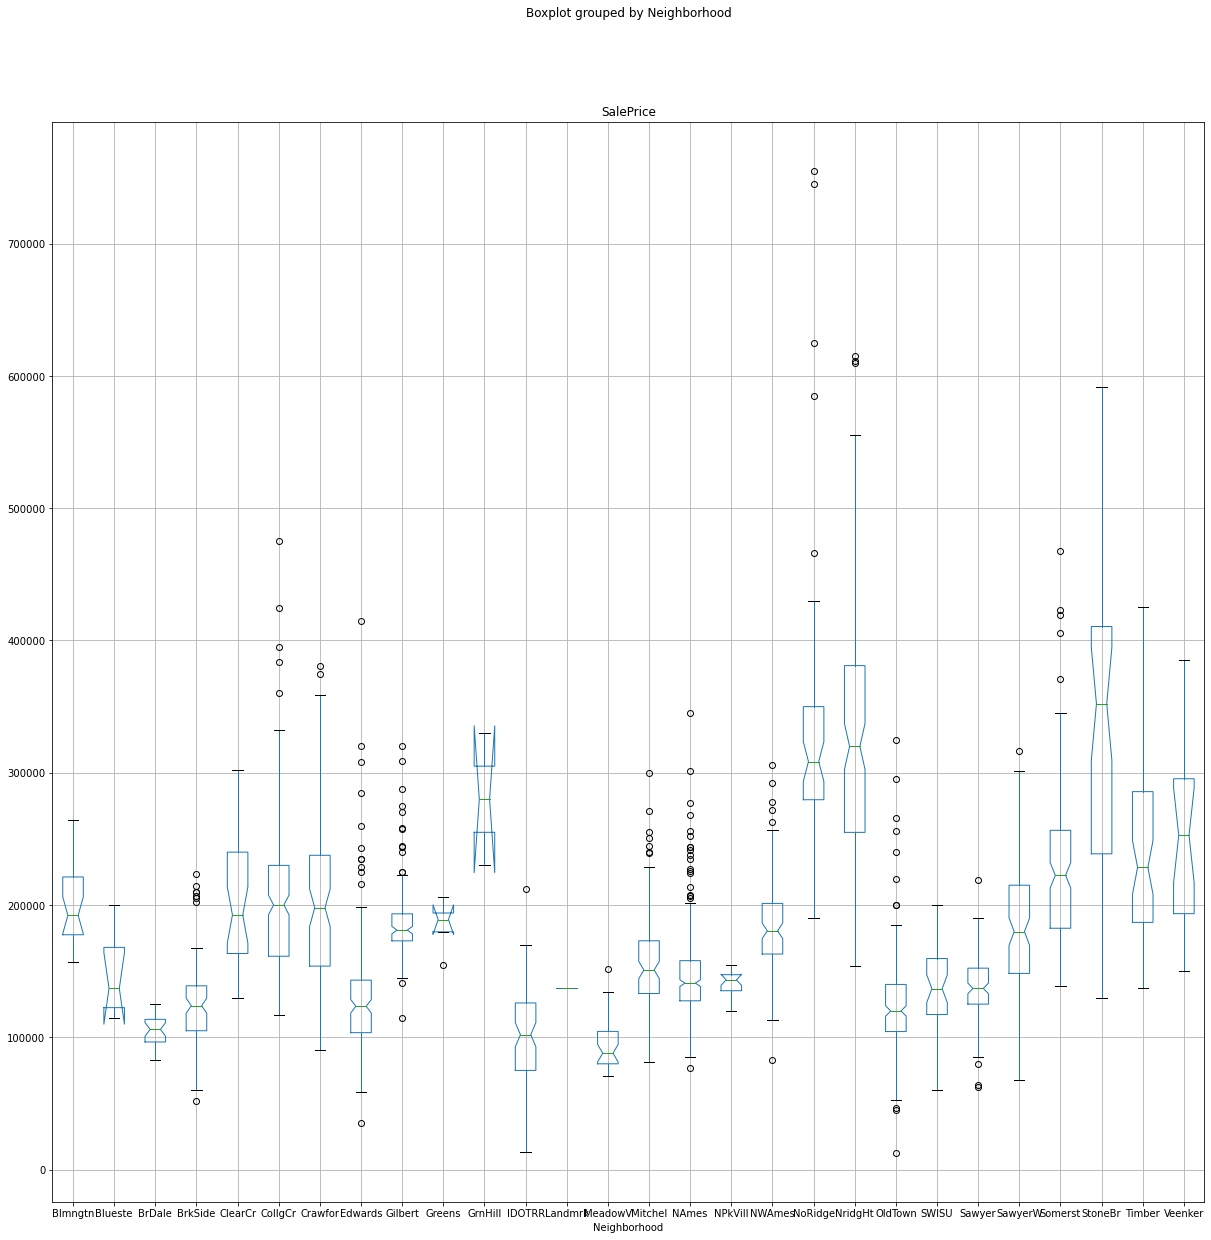

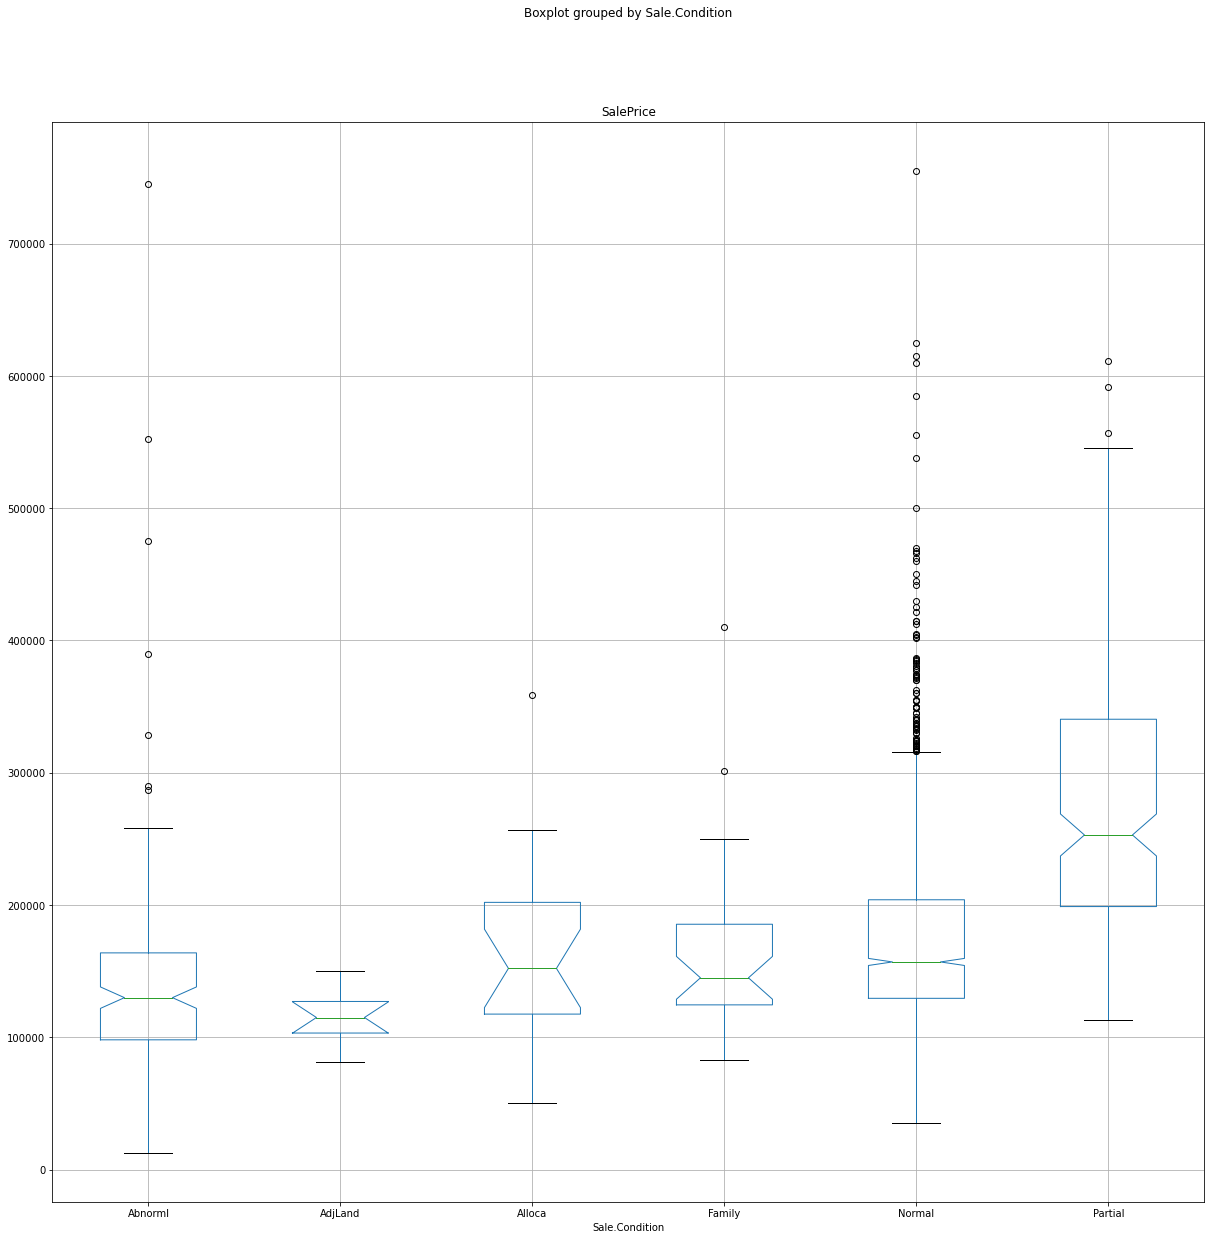

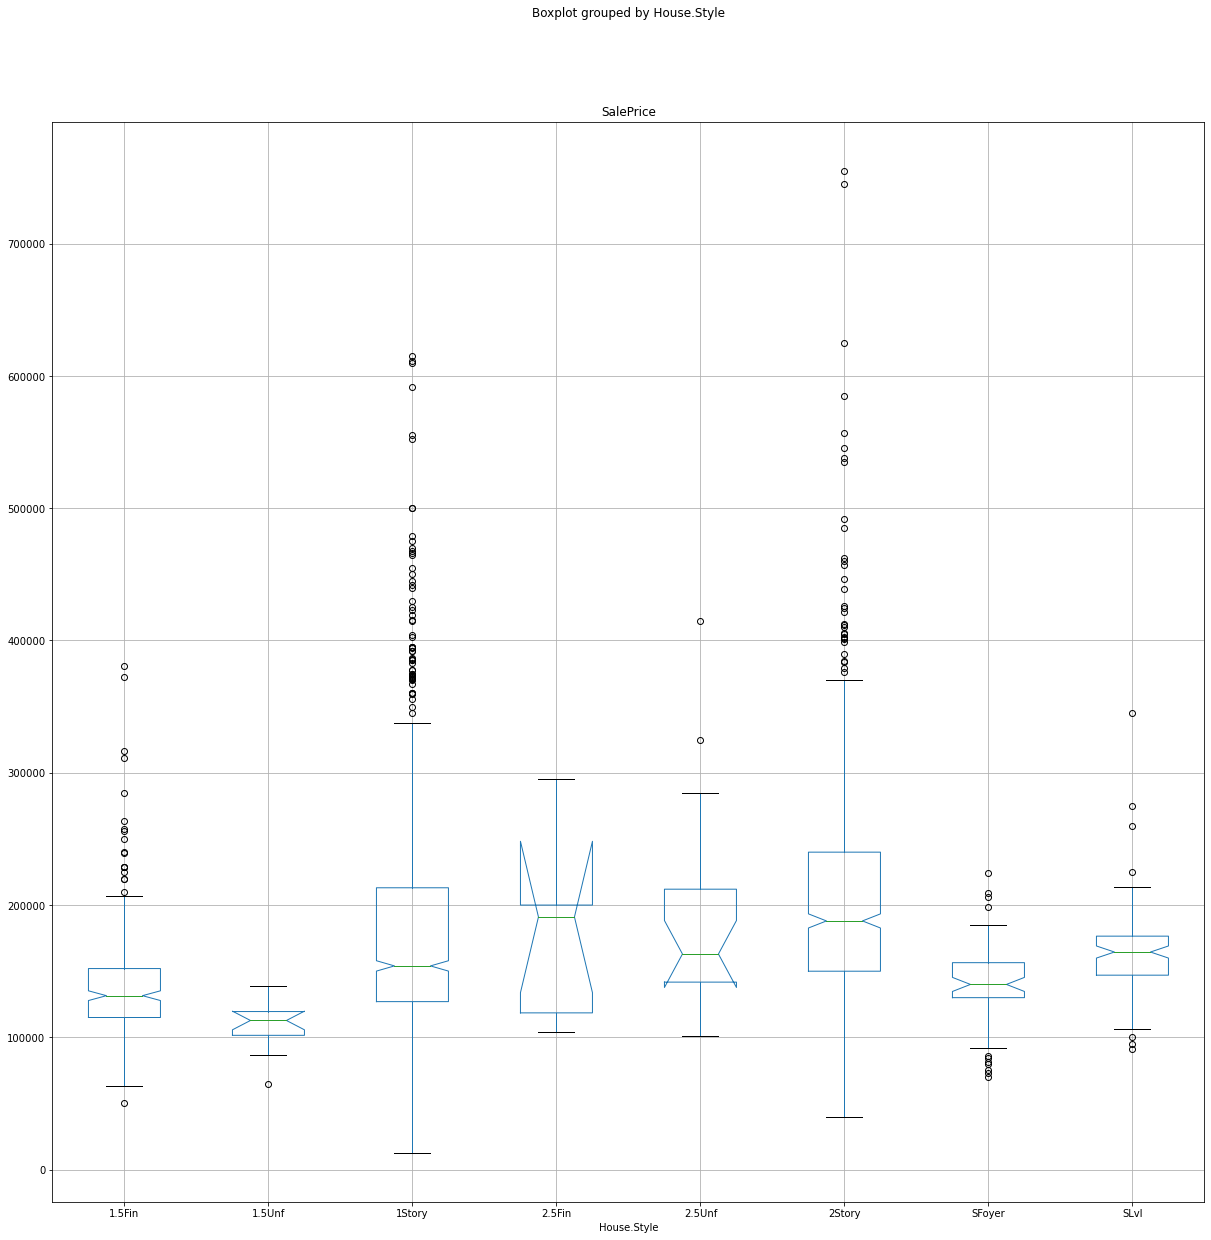

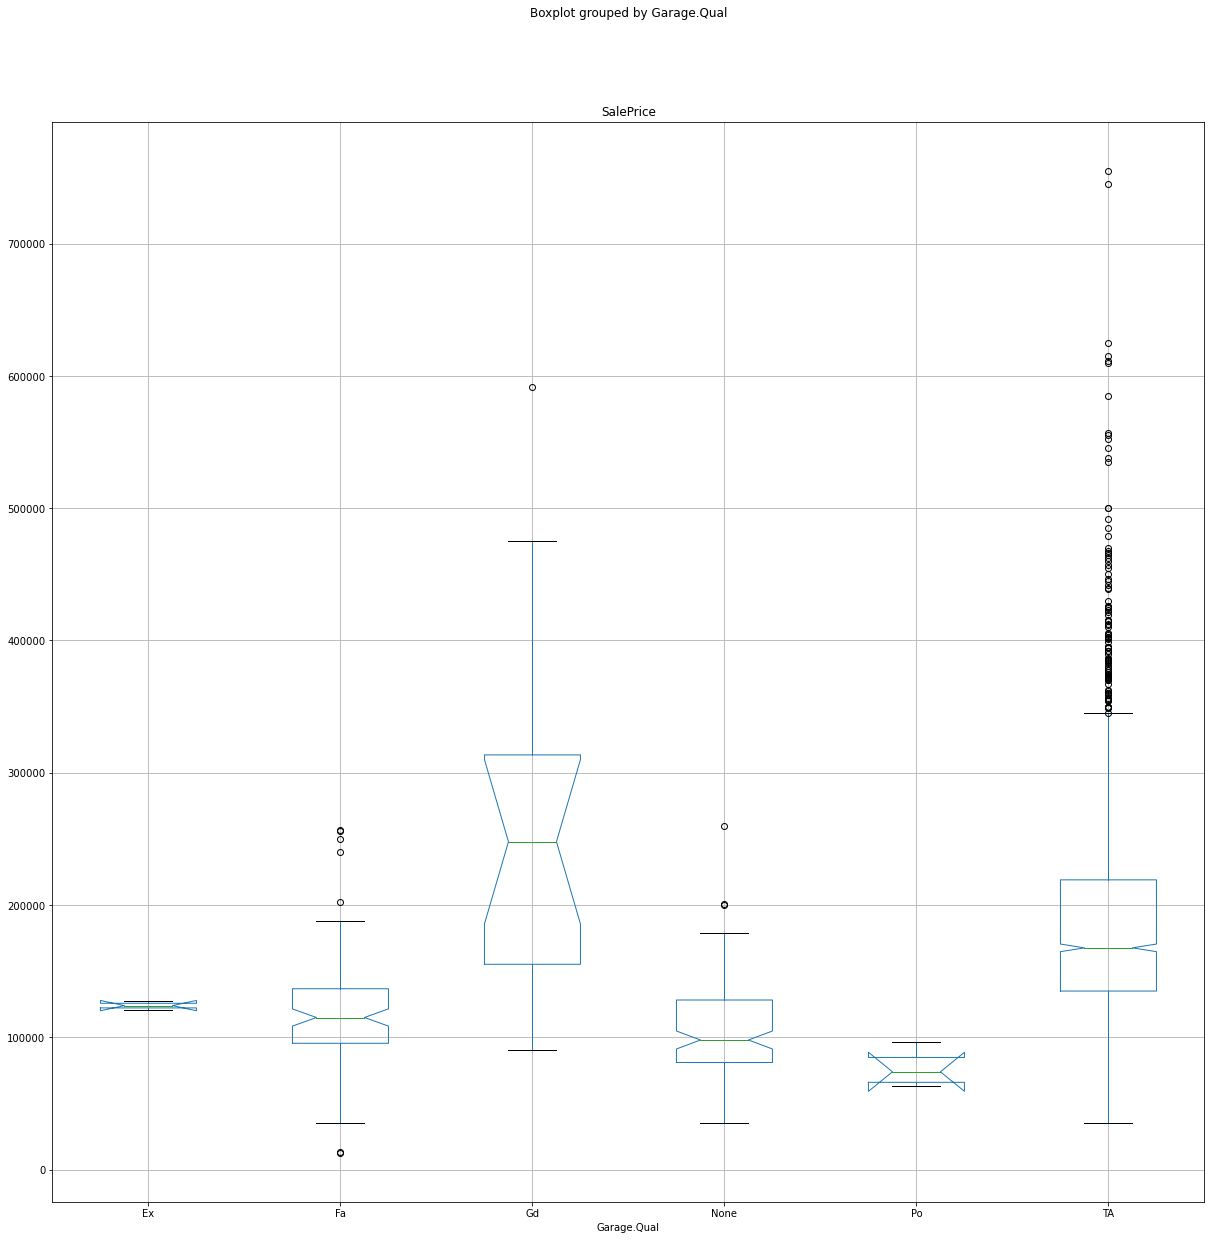

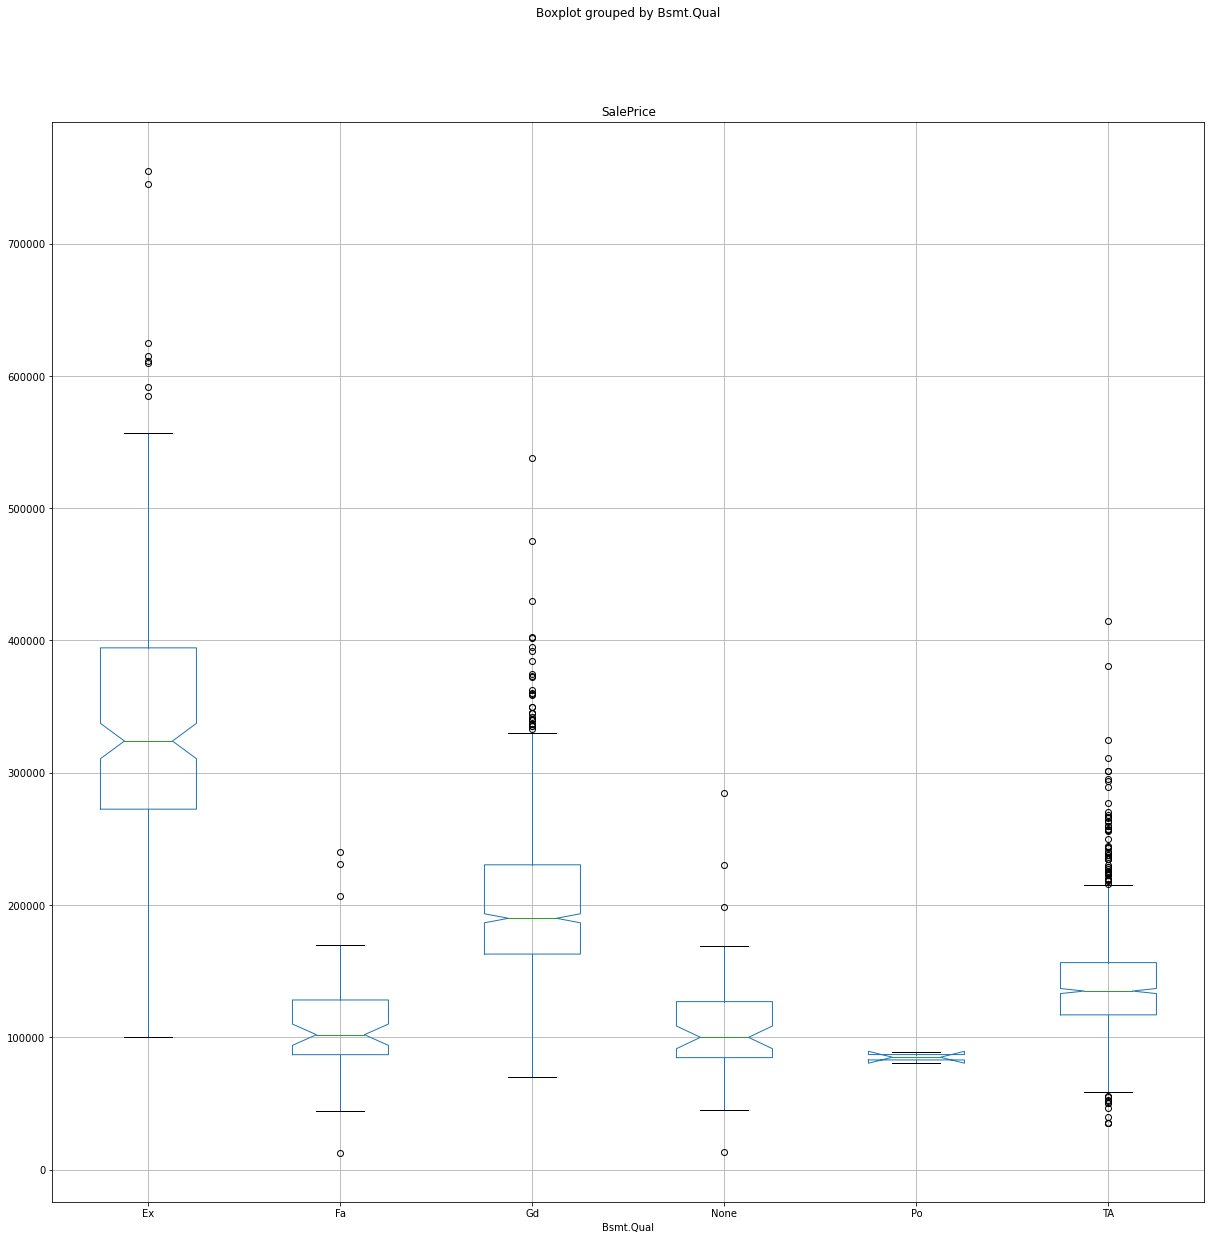

In [247]:
cat_cols = ['Neighborhood', 'Sale.Condition', 'House.Style', 'Garage.Qual', 'Bsmt.Qual']
cat_mod = pd.concat([cat_mod_x, model_y], axis=1)

for col in cat_cols:
    cat_mod.boxplot(column='SalePrice', by=col, notch=True)
    plt.show()

## Creating Baseline Model
As a control, let's construct a linear model and use all features to predict sales price.

### Train-Test Split

In [425]:
model_x_train, model_x_test, model_y_train, model_y_test = train_test_split(model_x, model_y, test_size=0.3)

def print_regression_error_report(y_test, preds):
    print('MSE, MAE, R^2, EVS: ' + str([mean_squared_error(y_test, preds), 
                                        median_absolute_error(y_test, preds),
                                        r2_score(y_test, preds),
                                        explained_variance_score(y_test, preds)]))

### Evaluate Linear Model
The mean squared and average errors are both very high for the linear baseline model. About eighty percent of all the features explain the differences observed in sales price, according to R-squared and EVS values. 

In [426]:
baseline = linear_model.LinearRegression()
baseline.fit(model_x_train, model_y_train)
preds = baseline.predict(model_x_test)
print_regression_error_report(model_y_test, preds)

MSE, MAE, R^2, EVS: [1184303106.4515862, 16832.960220482724, 0.81335262201130953, 0.81373841437650274]


## Creating Lasso Model
Since many outliers exist and values in the dataset are correlated (such as garage area and cars), let's build a Lasso regression model from sklearn to penalized these correlated predictors. 

### Finding Best Alpha Value
We will need to try several values for alpha to find the optimal penalty for larger absolute values and coefficients.

In [306]:
alphas = list(np.arange(5, 15, 0.5))

for a in alphas:
    lasso = linear_model.Lasso(alpha=a, normalize=True, fit_intercept=True)
    lasso.fit(model_x_train, model_y_train)
    preds = lasso.predict(model_x_test)
    print("Error report for alpha =", a)
    print_regression_error_report(model_y_test, preds)
    print()

Error report for alpha = 5.0
MSE, MAE, R^2, EVS: [393423772.91288561, 8638.5914001464844, 0.92830812552931441, 0.92878676021380169]

Error report for alpha = 5.5
MSE, MAE, R^2, EVS: [392705002.40503025, 8644.9048156738281, 0.92843910390065398, 0.92892928928282414]

Error report for alpha = 6.0
MSE, MAE, R^2, EVS: [391832502.85553759, 8658.6015930175781, 0.9285980956354819, 0.92910058022055209]

Error report for alpha = 6.5
MSE, MAE, R^2, EVS: [391274393.82204002, 8681.3307800292969, 0.92869979737677277, 0.92920802693232341]

Error report for alpha = 7.0
MSE, MAE, R^2, EVS: [391031697.00130349, 8685.5479736328125, 0.92874402294524272, 0.92925350008840835]

Error report for alpha = 7.5
MSE, MAE, R^2, EVS: [390832026.11445123, 8763.6683959960938, 0.92878040808803597, 0.92928763230902456]

Error report for alpha = 8.0
MSE, MAE, R^2, EVS: [390632035.89654619, 8889.3901977539063, 0.92881685142111481, 0.92931776706278557]

Error report for alpha = 8.5
MSE, MAE, R^2, EVS: [390441293.01413041, 

### Best Lasso Model
The model with the lowest mean-squared error (~400 million) and mean average error (~8000) has an alpha = 7.0. In this model, both the R-squared and explained variance scores are ~0.93 (the highest for alphas between 5 and 14.5, in increments of 0.5). This means that 93 percent of the differences in the house sale price are explained by differences in the model's chosen features.

In [373]:
lasso = linear_model.Lasso(alpha=7.0, normalize=True, fit_intercept=True)
lasso.fit(model_x_train, model_y_train)
preds = lasso.predict(model_x_test)
print_regression_error_report(model_y_test, preds)

MSE, MAE, R^2, EVS: [389721834.00823188, 8320.3243408203125, 0.94018404458263449, 0.94060018893760433]


In [376]:
print(valid_x.shape)
print(model_x.shape)

(586, 869)
(2344, 2656)


## Validation
Let's run the baseline and lasso models through our validation set, to see if the models generalize well to new data.

In [374]:
#baseline.fit(valid_x, valid_y)
base_preds = baseline.predict(valid_x)

#lasso.fit(valid_x, valid_y)
lasso_preds = lasso.predict(valid_x)

print("Error Metrics for Baseline:")
print_regression_error_report(valid_y, base_preds)
print()

print("Error Metrics for Lasso:")
print_regression_error_report(valid_y, lasso_preds)

ValueError: shapes (586,869) and (2656,) not aligned: 869 (dim 1) != 2656 (dim 0)